# Investigating Fandango Movie Ratings

[Fandango](https://www.fandango.com/) is a movie rating website just like [imdb](https://www.imdb.com/) and [RottenTomatoes](https://www.rottentomatoes.com/). Its rating system is 5-star rating system, where minimum is 0 stars and maximum is 5 stars.

### Is Fandango Still Inflating Ratings?

In Oct. 2015, a data journalist Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest. He published the analysis in [this article](https://fivethirtyeight.com/features/fandango-movies-ratings/). 

In this project, we'll analyze more recent movie ratings data to determine <b>whether there has been any change in Fandango's rating system after Hickey's analysis<\b>.

### Understanding the Data

In [28]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# we want to compare ratings before and after Hickey's analysis
# let's read in both datasets
r_before = pd.read_csv("fandango_score_comparison.csv")
r_after = pd.read_csv("movie_ratings_16_17.csv")

# overview columns
r_before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
FILM                          146 non-null object
RottenTomatoes                146 non-null int64
RottenTomatoes_User           146 non-null int64
Metacritic                    146 non-null int64
Metacritic_User               146 non-null float64
IMDB                          146 non-null float64
Fandango_Stars                146 non-null float64
Fandango_Ratingvalue          146 non-null float64
RT_norm                       146 non-null float64
RT_user_norm                  146 non-null float64
Metacritic_norm               146 non-null float64
Metacritic_user_nom           146 non-null float64
IMDB_norm                     146 non-null float64
RT_norm_round                 146 non-null float64
RT_user_norm_round            146 non-null float64
Metacritic_norm_round         146 non-null float64
Metacritic_user_norm_round    146 non-null float64
IMDB_norm_round               146 n

In [4]:
r_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
movie           214 non-null object
year            214 non-null int64
metascore       214 non-null int64
imdb            214 non-null float64
tmeter          214 non-null int64
audience        214 non-null int64
fandango        214 non-null float64
n_metascore     214 non-null float64
n_imdb          214 non-null float64
n_tmeter        214 non-null float64
n_audience      214 non-null float64
nr_metascore    214 non-null float64
nr_imdb         214 non-null float64
nr_tmeter       214 non-null float64
nr_audience     214 non-null float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


Isolate the columns that offer information about Fandango's rating in separate variables so we have just the data we're interested in more readily available for later use.

In [5]:
# Select the columns we're interested in below 
f_before = r_before[["FILM","Fandango_Stars","Fandango_Ratingvalue","Fandango_votes","Fandango_Difference"]].copy()
f_before.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [6]:
# for the other data set, select the following columns
f_after = r_after[["movie","year","fandango"]].copy()
f_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0



Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. The population of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — previous and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From Hickey's article and from the README.md of the data set's repository, we can see that he used the following sampling criteria:

- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.
The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the data set's repository):

The movie must have been released in 2016 or later.
The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).
This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

## Changing the Goal of our Analysis

Since we found the sampling process were not random, and resulting samples are very unlikely to be representative of the population we're interested in. At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, <b>our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016</b>. This new goal should also be a fairly good proxy for our initial goal.


## Isolating the Samples We Need
With this new research goal, we have two populations of interest:

All Fandango's ratings for popular movies released in 2015.
All Fandango's ratings for popular movies released in 2016.
We need to be clear about what counts as popular movies. We'll use Hickey's benchmark of 30 fan ratings and count a movie as popular only if it has 30 fan ratings or more on Fandango's website.

Although one of the sampling criteria in our second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [6]:
sum(f_before["Fandango_votes"] < 30)

0

In [8]:
# we need to check number of ratings manually on Fandango's website
# ideally at least 8/10 movies have 30 fan ratings or more
r_after.sample(10, random_state=1)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
108,Mechanic: Resurrection,2016,38,5.6,29,41,4.0,1.90,2.80,1.45,2.05,2.0,3.0,1.5,2.0
206,Warcraft,2016,32,7.0,28,71,4.0,1.60,3.50,1.40,3.55,1.5,3.5,1.5,3.5
106,Max Steel,2016,22,4.6,0,38,3.5,1.10,2.30,0.00,1.90,1.0,2.5,0.0,2.0
107,Me Before You,2016,51,7.4,58,73,4.5,2.55,3.70,2.90,3.65,2.5,3.5,3.0,3.5
51,Fantastic Beasts and Where to Find Them,2016,66,7.5,73,81,4.5,3.30,3.75,3.65,4.05,3.5,4.0,3.5,4.0
33,Cell,2016,38,4.3,11,16,3.0,1.90,2.15,0.55,0.80,2.0,2.0,0.5,1.0
59,Genius,2016,56,6.5,51,45,3.5,2.80,3.25,2.55,2.25,3.0,3.0,2.5,2.0
152,Sully,2016,74,7.5,85,85,4.5,3.70,3.75,4.25,4.25,3.5,4.0,4.0,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0
31,Captain America: Civil War,2016,75,7.9,90,89,4.5,3.75,3.95,4.50,4.45,4.0,4.0,4.5,4.5


dataquest searched rating number of the samples above(set random_state=1) and resulted in 90% of the samples had over 30 ratings, so we could keep using data below.

In [8]:
f_before.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5


In [9]:
# we want to separate movies staged in 2015 & 2014
# we get a clue that there's year at the end of `FILM` column
# let's extract year out
f_before["Year"] = f_before["FILM"].str[-5:-1]
f_before.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


In [10]:
# review the staged year distribution
f_before["Year"].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [12]:
# extract the data which was released in 2015
f_2015 = f_before[f_before.Year == "2015"].copy()

# check again if there's only data of 2015
f_2015["Year"].value_counts() 

2015    129
Name: Year, dtype: int64

In [13]:
# review the staged year distribution
f_after["year"].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [14]:
# extract the data which was released in 2016
f_2016 = f_after[f_after["year"] == 2016].copy()

# check again if there's only data of 2016
f_2016["year"].value_counts()

2016    191
Name: year, dtype: int64

### Comparing Distribution Shapes for 2015 & 2016

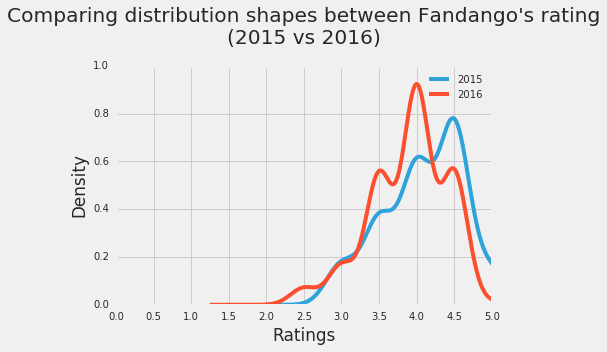

In [15]:
# make a kernal-density-estimate plot to review
# distribution change
from numpy import arange

# dataquest recommend using style below for better appearance
plt.style.use("fivethirtyeight")
f_2015["Fandango_Stars"].plot.kde(label="2015",legend=True)
f_2016["fandango"].plot.kde(label="2016",legend=True)
plt.title("Comparing distribution shapes between Fandango's rating\n(2015 vs 2016)", y=1.07)
plt.xlabel("Ratings")
plt.xlim(0,5)
# set x ticks from 0 to 5 with interval 0.5
# the tick 5 will be invisible if top of range set at 5
plt.xticks(arange(0,5.1,0.5))
plt.legend()
plt.show()

We found two characteristic from graph above:
- Both distributions are left-skewed. 
- movies in 2016 shifts a little to left relative to movies in 2015.

Based on my observation, there's indeed a change between Fandango's ratings for popular movies in 2015 and those in 2016. We can't be sure if this is because they have fixed the rounding bug they claimed or the movies in 2016 are really worse than 2015. We need more evidence to make a conclusion. But, generally the movies ratings in 2016 is lower than those of 2015.

### Comparing Relative Frequencies

Because the number of movies in both data is different, so we intend to normalize the distribution and analyze it further.

In [26]:
# generate the frequency distribution of 2015 in percentage
print("2015\n"+ "-"*16)
f_2015["Fandango_Stars"].value_counts(normalize=True).sort_index()*100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [20]:
# generate the frequency distribution of 2016 in percentage
print("2016\n"+ "-"*16)
f_2016["fandango"].value_counts(normalize=True).sort_index()*100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In [32]:
# calculate how ratings shift by assigning values in np.array
ratings_2015 = np.array([6.978744, 37.986696, 28.682171, 17.829457, 8.527132,0])
ratings_2016 = np.array([0.52346,24.607330,40.314136,24.083770,7.329843,3.141361])

In [33]:
# the percentage change by (2016 - 2015)
ratings_2016 - ratings_2015

array([ -6.455284, -13.379366,  11.631965,   6.254313,  -1.197289,
         3.141361])

Percentage is better for readibility than proportions, so we multiply by 100.

Fandango is reported that ratings were inflated. We get rating difference between 2015 & 2016 from calculation above. We can see 5 stars (-6.4%), 4.5 stars(-13.3%), 4 stars(+11.6%), 3.5 stars(+6.2%), 3 stars(-1.1%) and 2.5 stars(+3.14%).

We find the number of higher ratings (over 4.5 stars) seems shifted to middle ratings (3.5 ~ 4 stars), and lowest ratings is 2.5 stars ni 2016 which is half star lower than 2015.

Can this explain Fandango had fixed rounding system bug? We're not sure because we have to take into account the movie quality in 2015 & 2016. But one thing is for sure, the ratings were shifted toward left and 5 stars movies are less than before.

### Determine the Direction of the Change

In [45]:
mean_2015 = f_2015["Fandango_Stars"].mean()
median_2015 = f_2015["Fandango_Stars"].median()
mode_2015 = f_2015["Fandango_Stars"].mode().loc[0]

mean_2016 = f_2016["fandango"].mean()
median_2016 = f_2016["fandango"].median()
mode_2016 = f_2016["fandango"].mode().loc[0]

summary = pd.DataFrame()
summary["2015"] = [mean_2015, median_2015, mode_2015]
summary["2016"] = [mean_2016, median_2016, mode_2016]
summary.index = ["mean","median","mode"]

summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


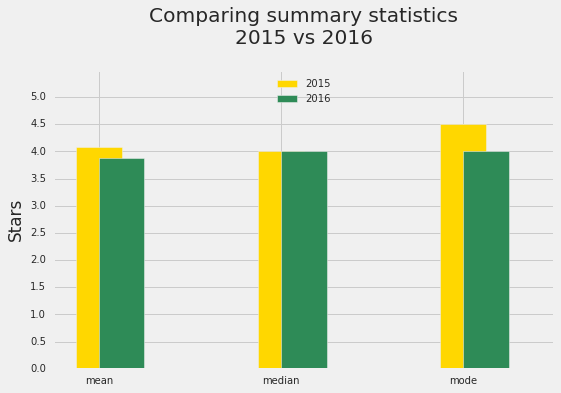

In [52]:
from numpy import arange

plt.style.use("fivethirtyeight")
# align in different positions to avoid overlapping
summary["2015"].plot.bar(color = "gold", label="2015",align="center", width=0.25)
summary["2016"].plot.bar(color = "seagreen", label="2016",align="edge", width=0.25
                         , rot=0,figsize=(8,5))

plt.title("Comparing summary statistics\n2015 vs 2016", y=1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,0.5))
plt.ylabel("Stars")
plt.legend(framealpha=0,loc="upper center")
plt.show()


Based on above, we can find median of 2015 & 2016 are the same. But mean and mode value of 2016 are both lower than 2015. We can determine that 2016 ratings are generally lower than 2015, but we can't be sure of accurate reason.